# Final Project Part 3- Technical Report

Nick (Leibao) Qi

**Overview**

- The malware industry continues to be a well-organized, well-funded market dedicated to evading traditional security measures. Once a computer is infected by malware, criminals can hurt consumers and enterprises in many ways. 
- With more than one billion enterprise and consumer customers, Microsoft takes this problem very seriously and is deeply invested in improving security.As one part of their overall strategy for doing so, Microsoft is challenging the data science community to develop techniques to predict if a machine will soon be hit with malware. Microsoft is providing an unprecedented malware dataset to encourage open-source progress on effective techniques for predicting malware occurrences.


**Goal**

- Predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine

**The Dataset**
- Includes properties of machines and records of machine infections collected by Windows Denfender


# Tabel of Content 

1. [Load Dataset](#data)
    <a href = '#data'></a>

2. [Exploratory Data Analysis](#EDA)
    <a href = '#EDA'></a>    
    
3. [Feature Engineering](#FE)
    <a href = '#FE'></a>     
    
4. [Data Modeling](#DM)
   <a href = '#DM'></a>    
    
5. [Evaluation](#EVA)
   <a href = 'EVA'></a> 

6. [Next Step](#NS)
   <a href = '#NEXT'></a>        

In [127]:
%matplotlib inline  

import time
import sys
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import gc

import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py
from IPython.display import Image


<a id ="data"></a>
**1. Load train and test dataset**

* Use chuncksize to check dataset first due to large size of data
* Change datatypes to reduce memeory use


In [2]:
reader = pd.read_csv('train.csv',chunksize=10)
type(reader)

pandas.io.parsers.TextFileReader

In [3]:
reader2 = pd.read_csv('test.csv',chunksize=10)

In [4]:
sample_chunk = None
for chunk in reader:
    sample_chunk = chunk
    print(sample_chunk)
    break

                  MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   
5  000016191b897145d069102325cab760  win8defender   1.1.15100.1   
6  0000161e8abf8d8b89c5ab8787fd712b  win8defender   1.1.15100.1   
7  000019515bc8f95851aff6de873405e8  win8defender   1.1.15100.1   
8  00001a027a0ab970c408182df8484fce  win8defender   1.1.15200.1   
9  00001a18d69bb60bda9779408dcf02ac  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0                 7                 0   
1     4.13.17134.1    1.263.48.0       0                 7                 0   
2  4.18.1807.18075  1.

In [5]:
sample_chunk2 = None
for chunk in reader2:
    sample_chunk2 = chunk
    break

In [6]:
# Number of columns in train: 83
sample_chunk.shape[1]

83

In [7]:
# Number of columns in test
sample_chunk2.shape[1]

82

In [8]:
sample_chunk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 83 columns):
MachineIdentifier                                    10 non-null object
ProductName                                          10 non-null object
EngineVersion                                        10 non-null object
AppVersion                                           10 non-null object
AvSigVersion                                         10 non-null object
IsBeta                                               10 non-null int64
RtpStateBitfield                                     10 non-null int64
IsSxsPassiveMode                                     10 non-null int64
DefaultBrowsersIdentifier                            0 non-null float64
AVProductStatesIdentifier                            10 non-null int64
AVProductsInstalled                                  10 non-null int64
AVProductsEnabled                                    10 non-null int64
HasTpm                                  

Optimse data types to fix reading issues 
* objects: categories
* Binary values: int8
* Binary values with missing values: float16 (int does not understand nan)
* 64 bits: 32, or 16 of possible

In [9]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [10]:
t_start = time.clock()
train = pd.read_csv('train.csv',dtype=dtypes)
t_end = time.clock()

print("Start Time: {}".format(t_start))
print("End Time: {}".format(t_end))

Start Time: 3.110202240900715e-07
End Time: 191.93537590681834


In [24]:
retained_cols= list(set(train.columns)-set(['HasDetections']))

t_start = time.clock()
test = pd.read_csv('test.csv',usecols = retained_cols,dtype=dtypes)
t_end = time.clock()

print("Start Time: {}".format(t_start))
print("End Time: {}".format(t_end))

Start Time: 717.9984137968571
End Time: 905.9707728075018


In [164]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 78 columns):
Census_FlightRing                                    category
SMode                                                float16
AVProductsInstalled                                  float16
Census_InternalBatteryNumberOfCharges                float32
ProductName                                          category
Census_OSUILocaleIdentifier                          int16
Census_IsVirtualDevice                               float16
SkuEdition                                           category
AutoSampleOptIn                                      int8
CityIdentifier                                       float32
Wdft_RegionIdentifier                                float16
Platform                                             category
Census_ThresholdOptIn                                float16
AppVersion                                           category
Census_ChassisTypeName           

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853253 entries, 0 to 7853252
Data columns (total 82 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float16
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                         

<a id ="EDA"></a>
**2. Exploratory Data Analysis**

* Handle missing values
* Handle columns that has high cardinality 


In [26]:
#Check first few rows of the training dataset
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [27]:
#Large dataset to analysze: 8.9 million rows and 83 columns
train.shape

(8921483, 83)

In [28]:
# Check numerical columns 
pd.options.display.float_format = "{:.2f}".format
train.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,8921483.00,8889165.00,8921483.00,433438.00,8885262.00,8885262.00,8885262.00,8921483.00,8921483.00,8596074.00,...,8761350.00,8921483.00,3261780.00,8905530.00,8921483.00,8921483.00,8850140.00,8618032.00,8618032.00,8921483.00
mean,0.00,nan,0.02,nan,49483.20,nan,nan,0.99,108.05,80491.52,...,32680.55,0.49,0.00,0.01,0.13,0.04,nan,nan,nan,0.50
std,0.00,0.00,0.13,nan,13799.94,0.00,0.00,0.11,63.05,48734.61,...,21126.12,0.50,0.00,0.08,0.33,0.19,0.00,0.00,0.00,0.50
min,0.00,0.00,0.00,1.00,3.00,0.00,0.00,0.00,1.00,5.00,...,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,0.00,7.00,0.00,788.00,49480.00,1.00,1.00,1.00,51.00,36825.00,...,13156.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00
50%,0.00,7.00,0.00,1632.00,53447.00,1.00,1.00,1.00,97.00,82373.00,...,33070.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,0.00
75%,0.00,7.00,0.00,2372.00,53447.00,2.00,1.00,1.00,162.00,123700.00,...,52436.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,11.00,1.00
max,1.00,35.00,1.00,3212.00,70507.00,7.00,5.00,1.00,222.00,167962.00,...,72105.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,15.00,1.00


Handle missing values

In [29]:
# Check missing data in training dataset
total_train_missing = train.isnull().sum().sort_values(ascending = False)
train_missing_percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total_train_missing, train_missing_percent], axis=1, keys=['Total', 'Percent'])

In [30]:
missing_train_data.head(10)

,Total,Percent
PuaMode,8919174,99.97
Census_ProcessorClass,8884852,99.59
DefaultBrowsersIdentifier,8488045,95.14
Census_IsFlightingInternal,7408759,83.04
Census_InternalBatteryType,6338429,71.05
Census_ThresholdOptIn,5667325,63.52
Census_IsWIMBootEnabled,5659703,63.44
SmartScreen,3177011,35.61
OrganizationIdentifier,2751518,30.84
SMode,537759,6.03


**Comment:**

* Data Dictionary:
    * PuaMode - Pua Enabled mode from the service
    * Census_ProcessorClass - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
    * DefaultBrowsersIdentifier - ID for the machine's default browser
    * Census_IsFlightingInternal - NA
    * Census_InternalBatteryType - NA


* Drop columns that has missing values over 70%

In [31]:
train.Census_IsFlightingInternal.unique()

array([nan,  0.,  1.])

In [32]:
train.Census_InternalBatteryType.unique()

[NaN, lion, li-i, #, lip, ..., 8, #TAB#, l&#TAB#, liÿÿ, lÿÿÿ]
Length: 79
Categories (78, object): [lion, li-i, #, lip, ..., #TAB#, l&#TAB#, liÿÿ, lÿÿÿ]

In [33]:
#Drop columns that have missing percentage over 70%
bad_cols = missing_train_data.loc[missing_train_data.Percent>70].transpose().columns
bad_cols

Index(['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier',
       'Census_IsFlightingInternal', 'Census_InternalBatteryType'],
      dtype='object')

In [82]:
#Drop columns that have missing percentage over 80%
cols = list(set(train.columns)-set(bad_cols))

In [83]:
len(cols)

78

In [84]:
train = train.loc[:,cols]

In [85]:
#Numerical columns
cols = train.columns
num_cols = train._get_numeric_data().columns
len(num_cols)

51

In [86]:
#Categorical columns
cat_cols = list(set(cols)-set(num_cols))
len(cat_cols)

27

Use data dictionary to identify true numerical values and binary values

In [87]:
#True numerical values
true_num_cols = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

In [88]:
#Binary values
bi_cols = [c for c in train.columns if train[c].nunique() == 2]
bi_cols

['IsProtected',
 'Census_ThresholdOptIn',
 'HasTpm',
 'Census_IsPortableOperatingSystem',
 'Wdft_IsGamer',
 'IsBeta',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'SMode',
 'HasDetections',
 'Census_IsVirtualDevice',
 'IsSxsPassiveMode',
 'Census_HasOpticalDiskDrive',
 'Census_IsWIMBootEnabled',
 'Census_IsFlightsDisabled',
 'Firewall',
 'Census_IsTouchEnabled',
 'Census_IsSecureBootEnabled',
 'AutoSampleOptIn',
 'Census_IsPenCapable']

In [89]:
cat_cols = list(set(cols)-set(true_num_cols)-set(bi_cols))
len(cat_cols)

51

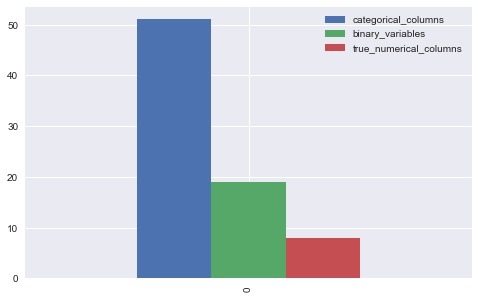

In [54]:
col_df = pd.DataFrame({'categorical_columns': [len(cat_cols)], 
                       'binary_variables': [len(bi_cols)],
                       'true_numerical_columns': [len(true_num_cols)]})
col_df.plot(kind='bar',figsize=(8,5));

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



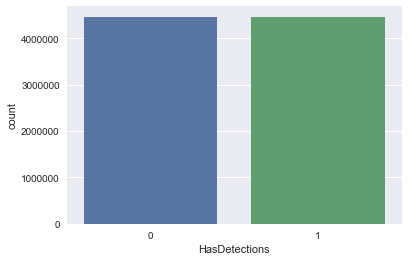

In [55]:
# Check target distribution in the training dataset
sns.countplot('HasDetections', data=train);
# We can see that the distribution of target is evenly split.

Check categorical values frist:
* Find varaibles with high cardinality 

In [52]:
train[cat_cols].nunique().sort_values(ascending=False)

MachineIdentifier                         8921483
Census_OEMModelIdentifier                  175365
CityIdentifier                             107366
Census_FirmwareVersionIdentifier            50494
AVProductStatesIdentifier                   28970
AvSigVersion                                 8531
Census_ProcessorModelIdentifier              2583
Census_OEMNameIdentifier                     2564
Census_FirmwareManufacturerIdentifier         712
OsBuildLab                                    663
Census_OSVersion                              469
IeVerIdentifier                               303
GeoNameIdentifier                             292
Census_OSBuildRevision                        285
LocaleEnglishNameIdentifier                   252
CountryIdentifier                             222
Census_OSBuildNumber                          165
Census_OSUILocaleIdentifier                   147
AppVersion                                    110
OsBuild                                        76


In [56]:
high_cardinality_columns = [c for c in cat_cols if train[c].nunique() > 2000]

In [57]:
high_cardinality_columns

['AVProductStatesIdentifier',
 'Census_FirmwareVersionIdentifier',
 'CityIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'AvSigVersion',
 'MachineIdentifier']

In [65]:
#Visulaization
cardinality = []
for c in cat_cols:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~qixxx062/0 or inside your plot.ly account where it is named 'plot from API'


<a id ="FE"></a>
**3. Feature Engineering**

Deal with categorical data: One hot encoding is excluded
* Frequency encoding: 
    * Rank the categories with respect to their frequencies 
* Label encoding:
    * Encode labels with value between 0 to classes-1
    

In [67]:
high_cardinality_columns.remove('MachineIdentifier')

In [100]:
high_cardinality_columns

['AVProductStatesIdentifier',
 'Census_FirmwareVersionIdentifier',
 'CityIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'AvSigVersion']

In [101]:
# Frequency encoding function
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [104]:
# tqdm: show a progress metter while looping
for col in tqdm(high_cardinality_columns):
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[col] = test[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

100%|██████████| 7/7 [00:51<00:00,  6.52s/it]


In [107]:
len(cat_cols)

44

In [115]:
#Label encoding
indexer = {}
for col in tqdm(cat_cols):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(cat_cols):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])
    

100%|██████████| 44/44 [43:49<00:00, 50.99s/it] 


In [116]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [117]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1468.61 Mb (65.6% reduction)
Mem. usage decreased to 1376.02 Mb (64.2% reduction)


In [119]:
train.shape

(8921483, 78)

<a id ="DM"></a>
**4. Data Modeling**


**Light GBM**

* A gradient boosting framewoork that uses tree based learning algorithm: Light GBM grows tree vertically while other algorithm grows trees horizontally.
* Adavantage:
    * High speed when handle large size of data
    * Lower memory use to run
* Disadvantage:
    * Not good on samll dataset and sensitive to overfit

<img src='lightgbm.png'>

<img src='leveltree.png'>

** Background Info**

* Ensemble: a collection of predictors which come together to give a final prediction. (Ex: mean of all predictions...)
    * Bagging:
        * An ensembling technique in which we build many independent predictors, models, or learners and combine them using some averaging techniques. (Ex: majority vote...)
        * Usually we take random sub-sample/bootstrap of data for each model,so that all the models are little different from each other. Each observation is chosen with replacement to be used as input for each of the model. So, each model will have different observations based on the bootstrap process. Because this technique takes many uncorrelated learners to make a final model, it reduces error by reducing variance. (Ex: Random forest)
<img src="randomsampling.png">                
              
    * Boosting: 
        * An ensemble technique in which the predictors are made sequentially and not independently.
        * The logic is that the subsequent predictors learn from the mistakes of the previous predictors. Therefore, the observations have an unequal probablity of appearing in subsequent models and ones witht he highest error most. So the observations are not chosen based on the bootstrap process, but based on the error (Ex: Gradient Boosting)
<img src="elementweighted.png">

    * Gradiant Boosting:
        *  a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees
        * Alogrithm:
            * Define a loss function and minimize it
            <img src="lossfunc.png">
            * Use gradient descent and update predictions based on a learning rate, then find the values where MSE is minimum.
            <img src="gradiantfunc.png">
        * Intuition: leverage the patterns in residuals and strengthen a model with weak predictions and make it better

In [113]:
# Use 'binary' as objective because this is a classification problem 
# Use 'bossting type' becasue it is to implement gradiant gradiant boosting  
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 42,
         "verbosity": -1}

**Parameter Tunning**

* num_leaves: main parameter to control the complexity of the tree model; value of num_leaves should be less than or qual to 2^(max_depth)
* min_data_in_leaf: a large value can avoid growing too deep in a tree, which may cuase under-fitting
* max_depth: limit the tree depth explicitly

For faster speed:

* Set feature_fraction to sub-sample 
* Set bagging_fraction and bagginh_freq

For better accuracy:
* Use small learning_rate with large num_iterations

For over-fitting:
* Try lambda_l1, lambda_l2 and min_gain_to_split to regularization

In [128]:
# Cross validation with n_splits =5
folds = KFold(n_splits=5, shuffle=True, random_state=15)

In [123]:
target = train.loc[:,'HasDetections']

In [124]:
train1 = train.drop(['HasDetections', 'MachineIdentifier'], axis=1)
test1 = test.drop(['MachineIdentifier'], axis=1)

In [134]:
#Convert dataset into LightGBM dataset format
features = list(train1.columns)
oof_lgb = np.zeros(len(train1))
predictions_lgb = np.zeros(len(test1))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train1.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train1.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train1.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=150)
    oof_lgb[val_idx] = clf.predict(train1.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test1[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 150 rounds.
[100]	training's auc: 0.718414	valid_1's auc: 0.717421
[200]	training's auc: 0.726579	valid_1's auc: 0.725004
[300]	training's auc: 0.730461	valid_1's auc: 0.728226
[400]	training's auc: 0.733049	valid_1's auc: 0.7301
[500]	training's auc: 0.735088	valid_1's auc: 0.731391
[600]	training's auc: 0.736791	valid_1's auc: 0.732313
[700]	training's auc: 0.738362	valid_1's auc: 0.733122
[800]	training's auc: 0.739777	valid_1's auc: 0.733743
[900]	training's auc: 0.741114	valid_1's auc: 0.734276
[1000]	training's auc: 0.742334	valid_1's auc: 0.734707
[1100]	training's auc: 0.743523	valid_1's auc: 0.735132
[1200]	training's auc: 0.744534	valid_1's auc: 0.735365
[1300]	training's auc: 0.7456	valid_1's auc: 0.735679
[1400]	training's auc: 0.746619	valid_1's auc: 0.735924
[1500]	training's auc: 0.7476	valid_1's auc: 0.736145
[1600]	training's auc: 0.748603	valid_1's auc: 0.736357
[1700]	training's auc: 0.74953	valid_1's auc: 0

[4170]	training's auc: 0.769	valid_1's auc: 0.738734
-
Fold 4
Training until validation scores don't improve for 150 rounds.
[100]	training's auc: 0.718218	valid_1's auc: 0.718384
[200]	training's auc: 0.726168	valid_1's auc: 0.725774
[300]	training's auc: 0.730008	valid_1's auc: 0.728995
[400]	training's auc: 0.732693	valid_1's auc: 0.731001
[500]	training's auc: 0.734818	valid_1's auc: 0.732391
[600]	training's auc: 0.736673	valid_1's auc: 0.733477
[700]	training's auc: 0.738127	valid_1's auc: 0.734165
[800]	training's auc: 0.7396	valid_1's auc: 0.734837
[900]	training's auc: 0.740919	valid_1's auc: 0.735365
[1000]	training's auc: 0.742152	valid_1's auc: 0.735826
[1100]	training's auc: 0.743281	valid_1's auc: 0.736183
[1200]	training's auc: 0.744402	valid_1's auc: 0.736526
[1300]	training's auc: 0.745468	valid_1's auc: 0.736808
[1400]	training's auc: 0.746474	valid_1's auc: 0.737064
[1500]	training's auc: 0.747505	valid_1's auc: 0.737328
[1600]	training's auc: 0.748458	valid_1's auc:

In [138]:
predictions_lgb

array([0.50960066, 0.55493305, 0.45925714, ..., 0.44468535, 0.46423598,
       0.45905428])

<a id ="EVA"></a>
**5. Evaluation**

* Upload to Kaggle for evaluation

In [139]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions_lgb
sub_df[:10]


,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.51
1,00000176ac758d54827acd545b6315a5,0.55
2,0000019dcefc128c2d4387c1273dae1d,0.46
3,0000055553dc51b1295785415f1a224d,0.49
4,00000574cefffeca83ec8adf9285b2bf,0.57
5,000007ffedd31948f08e6c16da31f6d1,0.57
6,000008f31610018d898e5f315cdf1bd1,0.34
7,00000a3c447250626dbcc628c9cbc460,0.19
8,00000b6bf217ec9aef0f68d5c6705897,0.16
9,00000b8d3776b13e93ad83676a28e4aa,0.41


In [140]:
sub_df.to_csv("submit.csv", index=False)

<a id ="NS"></a>
**6. Next Step**

1. Cleaner dataset
2. Feature engineering 
3. Modeling options:
    * Neural Network 
    * Time Series 

** Appendix **

In [95]:
# check AvSigVersion
# AvSigVersion - Defender state information e.g. 1.217.1014.0
data_train['AvSigVersion'].value_counts()[:10]

1.273.1420.0    102317
1.263.48.0       98024
1.275.1140.0     97232
1.275.727.0      92448
1.273.371.0      86967
1.273.1826.0     86013
1.275.1244.0     78902
1.251.42.0       76837
1.275.1209.0     66393
1.273.810.0      65895
Name: AvSigVersion, dtype: int64

In [96]:
data_train['OsBuildLab'].value_counts()[:10]                                                    

17134.1.amd64fre.rs4_release.180410-1804                 3658199
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    1252674
16299.15.amd64fre.rs3_release.170928-1534                 961060
15063.0.amd64fre.rs2_release.170317-1834                  718033
17134.1.x86fre.rs4_release.180410-1804                    257074
16299.15.x86fre.rs3_release.170928-1534                   233449
14393.2189.amd64fre.rs1_release.180329-1711               193636
10240.17443.amd64fre.th1.170602-2340                      171990
10586.1176.amd64fre.th2_release_sec.170913-1848           148259
15063.0.x86fre.rs2_release.170317-1834                     62237
Name: OsBuildLab, dtype: int64

In [97]:
data_train['Census_OSVersion'].value_counts()[:10]

10.0.17134.228     1413627
10.0.17134.165      899711
10.0.16299.431      546546
10.0.17134.285      470280
10.0.16299.547      346853
10.0.17134.112      346410
10.0.16299.371      325267
10.0.17134.191      228254
10.0.14393.2189     223775
10.0.16299.611      216776
Name: Census_OSVersion, dtype: int64

In [99]:
data_train['AppVersion'].value_counts()[:10]                                                              

4.18.1807.18075     5139224
4.18.1806.18062      850929
4.12.16299.15        359871
4.10.209.0           272455
4.13.17134.1         257270
4.16.17656.18052     235032
4.13.17134.228       226501
4.8.10240.17443      205480
4.9.10586.1106       203525
4.14.17639.18041     194699
Name: AppVersion, dtype: int64

In [102]:
data_train['EngineVersion'].value_counts()[:10]
# We can see that some of the categorical columns provide similar information. We can delete some of them to reduce the complexity

1.1.15200.1    3845067
1.1.15100.1    3675915
1.1.15000.2     265218
1.1.14901.4     212408
1.1.14600.4     160585
1.1.14800.3     136476
1.1.15300.6     120295
1.1.14104.0      93926
1.1.13504.0      70645
1.1.15300.5      68716
Name: EngineVersion, dtype: int64

In [134]:
high_cardinality_columns

['AvSigVersion', 'MachineIdentifier', 'OsBuildLab']

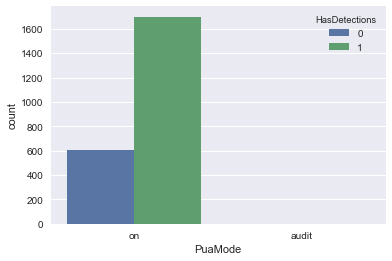

In [56]:
# Check columns that have lots of missing values
sns.countplot(x='PuaMode', hue='HasDetections',data=data_train);

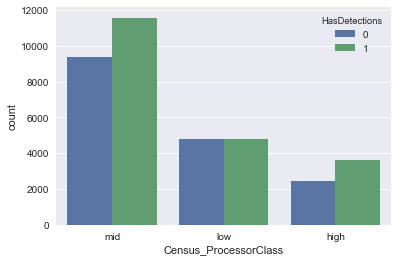

In [52]:
sns.countplot(x='Census_ProcessorClass', hue='HasDetections',data=data_train);

In [105]:
cols_to_remove = ['DefaultBrowsersIdentifier','Census_ProcessorClass' ,'PuaMode',
                  'Census_IsFlightingInternal', 'Census_InternalBatteryType',
                 'Census_ThresholdOptIn','Census_IsWIMBootEnabled']

data_train.drop(cols_to_remove, axis=1, inplace=True)

In [108]:
# Keep checking columns that have many nan values
data_train['SmartScreen'].describe()
# Potential solution to slove nan values: replace with its mode 

count          5744472
unique              21
top       RequireAdmin
freq           4316183
Name: SmartScreen, dtype: object

In [109]:
data_train['OrganizationIdentifier'].describe()

count   6169965.00
mean         24.86
std           5.61
min           1.00
25%          18.00
50%          27.00
75%          27.00
max          52.00
Name: OrganizationIdentifier, dtype: float64

In [107]:
# Check correlations 
corr = data_train.corr()['HasDetections']
abs(corr).sort_values(ascending=False)

HasDetections                                       1.00
AVProductsInstalled                                 0.15
AVProductStatesIdentifier                           0.12
Census_IsAlwaysOnAlwaysConnectedCapable             0.06
Census_TotalPhysicalRAM                             0.06
IsProtected                                         0.06
Census_ProcessorCoreCount                           0.05
Wdft_IsGamer                                        0.05
Census_IsVirtualDevice                              0.05
AVProductsEnabled                                   0.04
RtpStateBitfield                                    0.04
Census_IsTouchEnabled                               0.04
IsSxsPassiveMode                                    0.04
Census_InternalPrimaryDiagonalDisplaySizeInInches   0.03
Census_InternalPrimaryDisplayResolutionHorizontal   0.03
Census_OSBuildNumber                                0.03
Census_FirmwareManufacturerIdentifier               0.03
OsBuild                        